## Imports

In [234]:
import csv
import pandas as pd

import sklearn.ensemble

import sklearn.model_selection
import sklearn.preprocessing
import sklearn.impute
import sklearn.pipeline
import sklearn.model_selection
import sklearn.compose

import sklearn.neighbors

import sklearn.metrics

import matplotlib.pyplot as plt
import sklearn.inspection

In [163]:
DROP_COLS = ['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
PATH = 'Files/'
FILE = 'BankChurners.csv'

## Data

In [164]:
# columns to keep
with open(f'{PATH}{FILE}', 'r') as f:
    r = csv.DictReader(f)
    cols = set(r.fieldnames).difference(set(DROP_COLS))
cols

{'Attrition_Flag',
 'Avg_Open_To_Buy',
 'Avg_Utilization_Ratio',
 'CLIENTNUM',
 'Card_Category',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Customer_Age',
 'Dependent_count',
 'Education_Level',
 'Gender',
 'Income_Category',
 'Marital_Status',
 'Months_Inactive_12_mon',
 'Months_on_book',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Ct_Chng_Q4_Q1',
 'Total_Relationship_Count',
 'Total_Revolving_Bal',
 'Total_Trans_Amt',
 'Total_Trans_Ct'}

In [165]:
df = pd.read_csv(f'{PATH}{FILE}', usecols=cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

## Prep data

In [212]:
FLAG_COL = 'Attrition_Flag'

# Existing Customer > 1 
# Attrited Customer > 0 
x = df.drop([FLAG_COL], axis=1)
y = sklearn.preprocessing.LabelEncoder().fit_transform(df[FLAG_COL])

In [224]:
# Split the dataset into train / test set
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, train_size=0.8, random_state=3)

## Select cols

In [225]:
x_train_rf = pd.get_dummies(x_train)
y_train_rf = pd.get_dummies(y_train)
x_test_rf = pd.get_dummies(x_test)
y_test_rf = pd.get_dummies(y_test)

In [226]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=10)

rf.fit(x_train_rf, y_train_rf)
rf.score(x_test_rf, y_test_rf)

0.9378084896347483

In [227]:
# 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal', 'Avg_Utilization_Ratio'
feature_importance = pd.DataFrame(rf.feature_importances_, index=x_train_rf.columns, columns=['importance']).sort_values('importance', ascending=False)
cols_importance = feature_importance.index
cols_importance

Index(['Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Revolving_Bal',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Total_Relationship_Count', 'Total_Amt_Chng_Q4_Q1', 'Credit_Limit',
       'Months_on_book', 'CLIENTNUM', 'Avg_Open_To_Buy',
       'Months_Inactive_12_mon', 'Customer_Age', 'Contacts_Count_12_mon',
       'Dependent_count', 'Marital_Status_Married', 'Gender_F', 'Gender_M',
       'Marital_Status_Single', 'Income_Category_$40K - $60K',
       'Education_Level_Graduate', 'Income_Category_$80K - $120K',
       'Education_Level_High School', 'Income_Category_$60K - $80K',
       'Education_Level_Unknown', 'Income_Category_Less than $40K',
       'Education_Level_Uneducated', 'Education_Level_Post-Graduate',
       'Education_Level_Doctorate', 'Education_Level_College',
       'Income_Category_Unknown', 'Card_Category_Blue',
       'Income_Category_$120K +', 'Marital_Status_Divorced',
       'Marital_Status_Unknown', 'Card_Category_Gold', 'Card_Category_Silver',


In [237]:
feature_number = 2
x_train = x_train[cols_importance[:feature_number]]
x_test = x_test[cols_importance[:feature_number]]

## Model

In [238]:
# separate column types for 
#   - numeric
#   - categorical

# numpy dtype hierarchie: https://numpy.org/doc/stable/reference/arrays.scalars.html
num_cols = x_train.select_dtypes(include=['number']).columns
cat_cols = x_train.select_dtypes(exclude=['number']).columns

In [239]:
# SimpleImputer : set default value for missing value
# OneHotIncoder : encode cat > num values

num_transformer = sklearn.impute.SimpleImputer()  # strategy='mean'
cat_transformer = sklearn.pipeline.Pipeline(steps=[
    ('imputer', sklearn.impute.SimpleImputer(strategy='most_frequent')),
    ('onehot', sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = sklearn.compose.ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols),
])

### KNN

In [240]:
# prepare the pipeline

model = sklearn.neighbors.KNeighborsClassifier()

pipe = sklearn.pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model),
])

In [241]:
pipe.fit(x_train, y_train)
pred = pipe.predict(x_test)

# highest is the best
# all: 0.81
# b5: 0.90
# b3: 0.90
pipe.score(x_test, y_test)  # 1 - mae : sklearn.metrics.mean_absolute_error(y_true=y_test, y_pred=pred)

0.8953603158933859

## Graph

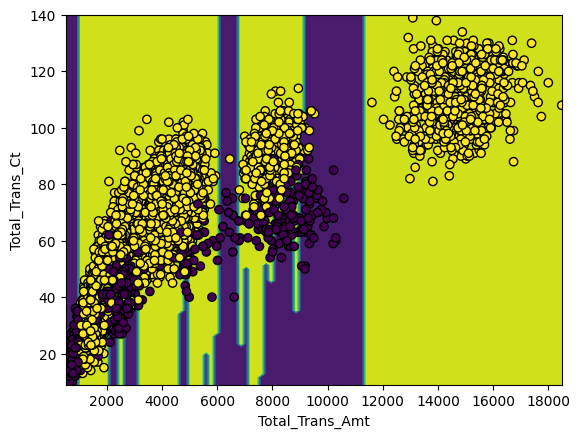

In [269]:
_, ax = plt.subplots()
disp = sklearn.inspection.DecisionBoundaryDisplay.from_estimator(
    pipe,
    x_train,
    ax=ax,
    response_method='predict',
)

disp.ax_.scatter(x_train.iloc[:, 0], x_train.iloc[:, 1], c=y_train, edgecolor="k")

plt.show()